In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.metrics import mean_squared_error

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [2]:
def generate_data(seq_length=1000, device='cpu'):
    x = np.linspace(0, 100, seq_length)
    y = np.sin(x)
    
    # Convert to torch tensors and move to the specified device
    x_tensor = torch.tensor(x, dtype=torch.float32).to(device)
    y_tensor = torch.tensor(y, dtype=torch.float32).to(device)
    
    return x_tensor, y_tensor

data = generate_data(device=device)

In [3]:
def generate_synthetic_data_univariate(seq_length=100, freq=0.1, noise_level=0.1, device='cpu'):
    t = np.linspace(0, seq_length * freq, seq_length)
    data = np.sin(t) + noise_level * np.random.randn(seq_length)
    
    # Convert to torch tensor and move to device
    data_tensor = torch.tensor(data, dtype=torch.float32).to(device)
    
    return data_tensor

def generate_synthetic_data_multivariate(seq_length=100, freq=0.1, noise_level=0.1, device='cpu'):
    t = np.linspace(0, seq_length * freq, seq_length)
    data1 = np.sin(t) + noise_level * np.random.randn(seq_length)
    data2 = np.cos(t) + noise_level * np.random.randn(seq_length)
    
    # Stack data and convert to torch tensor, then move to device
    data = np.column_stack([data1, data2])
    data_tensor = torch.tensor(data, dtype=torch.float32).to(device)
    
    return data_tensor

In [4]:
def create_sequences(data, seq_length, device='cpu'):
    X, Y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        Y.append(data[i + 1:i + seq_length + 1])  # Shift by 1 step
    
    # Convert to torch tensors and move to the device
    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    Y_tensor = torch.tensor(Y, dtype=torch.float32).to(device)
    
    return X_tensor, Y_tensor

seq_length = 20
X, Y = create_sequences(data, seq_length, device=device)

# Adding the extra dimension for input to match the model's expected input shape
X = X.unsqueeze(-1)  # Move to GPU (already done in create_sequences)
Y = Y.unsqueeze(-1)  # Move to GPU (already done in create_sequences)

# Splitting into train and test datasets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

In [5]:
class TransformerTimeSeries(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, dropout):
        super(TransformerTimeSeries, self).__init__()

        # Set the device to GPU if available, else CPU
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Input projection layer
        self.input_proj = nn.Linear(input_dim, model_dim)

        # Transformer layer
        self.transformer = nn.Transformer(
            d_model=model_dim,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dropout=dropout,
            batch_first=True
        )

        # Output layer
        self.output_layer = nn.Linear(model_dim, input_dim)

        # Move all layers to the device (GPU or CPU)
        self.to(self.device)

    def forward(self, src, tgt):
        # Move inputs to the correct device
        src = src.to(self.device)
        tgt = tgt.to(self.device)

        # Project inputs to model_dim
        src = self.input_proj(src)  # [batch_size, seq_len, model_dim]
        tgt = self.input_proj(tgt)

        # Permute to match transformer format
        src = src.permute(1, 0, 2)  # [seq_len, batch_size, model_dim]
        tgt = tgt.permute(1, 0, 2)

        # Forward through transformer
        output = self.transformer(src, tgt)

        # Permute back and map to original output dimension
        output = output.permute(1, 0, 2)
        return self.output_layer(output)

/tmp/ipykernel_31/2632295419.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  X_tensor = torch.tensor(X, dtype=torch.float32).to(device)


Epoch [10/100], Loss: 0.0826
Epoch [20/100], Loss: 0.1298
Epoch [30/100], Loss: 0.0877
Epoch [40/100], Loss: 0.0745
Epoch [50/100], Loss: 0.0729
Epoch [60/100], Loss: 0.0646
Epoch [70/100], Loss: 0.0582
Epoch [80/100], Loss: 0.0407
Epoch [90/100], Loss: 0.0192
Epoch [100/100], Loss: 0.0138
Training completed.


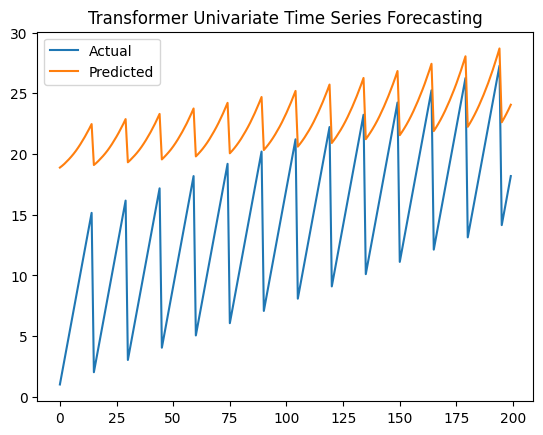

In [7]:
# Generate univariate data
seq_length = 100
data_univariate = generate_data(seq_length)  # Check this function's return value

# Check if generate_data returns a tuple, and extract the data array
if isinstance(data_univariate, tuple):
    data_univariate = data_univariate[0]  # Assuming the first element is the data

# Normalize data
scaler = MinMaxScaler()
data_univariate_scaled = scaler.fit_transform(data_univariate.reshape(-1, 1))

# Prepare sequences
window_size = 15
X_train_univariate, Y_train_univariate = create_sequences(data_univariate_scaled, window_size, device=device)

# Initialize Transformer model
input_dim = 1  # Univariate time series
model_dim = 64
num_heads = 4
num_layers = 2
dropout = 0.1

model = TransformerTimeSeries(input_dim, model_dim, num_heads, num_layers, dropout).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    Y_pred = model(X_train_univariate, X_train_univariate)

    # Compute loss
    loss = criterion(Y_pred, Y_train_univariate)

    # Backward pass
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

print("Training completed.")

# Make predictions
model.eval()
with torch.no_grad():
    Y_pred_univariate = model(X_train_univariate, X_train_univariate)

# Convert predictions back to original scale (move to CPU first)
Y_pred_univariate_np = scaler.inverse_transform(Y_pred_univariate.cpu().numpy().flatten().reshape(-1, 1))
Y_train_univariate_np = scaler.inverse_transform(Y_train_univariate.cpu().numpy().flatten().reshape(-1, 1))

# Plot results
plt.plot(Y_train_univariate_np[:200], label="Actual")
plt.plot(Y_pred_univariate_np[:200], label="Predicted")
plt.legend()
plt.title("Transformer Univariate Time Series Forecasting")
plt.show()

Epoch [10/100], Loss: 0.1042
Epoch [20/100], Loss: 0.1078
Epoch [30/100], Loss: 0.1009
Epoch [40/100], Loss: 0.0940
Epoch [50/100], Loss: 0.0720
Epoch [60/100], Loss: 0.0315
Epoch [70/100], Loss: 0.0225
Epoch [80/100], Loss: 0.0166
Epoch [90/100], Loss: 0.0166
Epoch [100/100], Loss: 0.0141
Training completed.


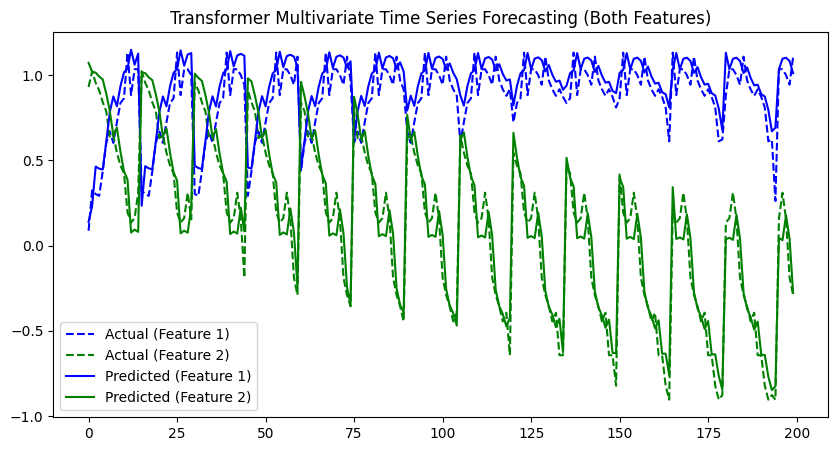

In [8]:
# Generate multivariate data
seq_length = 100
data_multivariate = generate_synthetic_data_multivariate(seq_length)

# Normalize data
scaler = MinMaxScaler()
data_multivariate_scaled = scaler.fit_transform(data_multivariate)

# Prepare sequences
window_size = 15
X_train_multivariate, Y_train_multivariate = create_sequences(data_multivariate_scaled, window_size, device=device)

# Initialize Transformer model
input_dim = data_multivariate.shape[1]  # Multivariate time series (number of features)
model_dim = 64
num_heads = 4
num_layers = 2
dropout = 0.1

model = TransformerTimeSeries(input_dim, model_dim, num_heads, num_layers, dropout).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    Y_pred = model(X_train_multivariate, X_train_multivariate)

    # Compute loss
    loss = criterion(Y_pred, Y_train_multivariate)

    # Backward pass
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

print("Training completed.")

# Make predictions
model.eval()
with torch.no_grad():
    Y_pred_multivariate = model(X_train_multivariate, X_train_multivariate)

# Convert predictions back to original scale (move to CPU first)
Y_pred_multivariate_np = scaler.inverse_transform(Y_pred_multivariate.cpu().numpy().reshape(-1, data_multivariate.shape[1]))
Y_train_multivariate_np = scaler.inverse_transform(Y_train_multivariate.cpu().numpy().reshape(-1, data_multivariate.shape[1]))

# Plot results
plt.figure(figsize=(10, 5))

# Plot actual values
plt.plot(Y_train_multivariate_np[:200, 0], label="Actual (Feature 1)", linestyle='dashed', color='blue')
plt.plot(Y_train_multivariate_np[:200, 1], label="Actual (Feature 2)", linestyle='dashed', color='green')

# Plot predicted values
plt.plot(Y_pred_multivariate_np[:200, 0], label="Predicted (Feature 1)", color='blue')
plt.plot(Y_pred_multivariate_np[:200, 1], label="Predicted (Feature 2)", color='green')

plt.legend()
plt.title("Transformer Multivariate Time Series Forecasting (Both Features)")
plt.show()

In [11]:
# Load Tesla stock data
df_tesla = pd.read_excel('/kaggle/input/stock-data/Tesla_Stock.xlsx')

# Drop unnecessary column
df_tesla = df_tesla.drop(columns=["Unnamed: 0"], errors="ignore")

# Convert date to datetime and set as index
df_tesla["Date"] = pd.to_datetime(df_tesla["Date"])
df_tesla.set_index("Date", inplace=True)

# Select only "Open" and "Close" prices
df_tesla = df_tesla[["Open", "Close"]]

# Normalize data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_tesla)

df_scaled = pd.DataFrame(scaled_data, columns=df_tesla.columns, index=df_tesla.index)

# Use the last 2000 data points (adjustable)
df_scaled = df_scaled.iloc[-2000:]

In [12]:
# Split data into 80% training, 20% testing
train_size = int(len(df_scaled) * 0.8)
df_train = df_scaled.iloc[:train_size]
df_test = df_scaled.iloc[train_size:]

print(f"Training data size: {len(df_train)}")
print(f"Testing data size: {len(df_test)}")

# Convert to numpy arrays (for sequence creation)
train_data_np = df_train.to_numpy()
test_data_np = df_test.to_numpy()

# Optionally, move data to the GPU if needed (ensure device is available)
train_data = torch.tensor(train_data_np, dtype=torch.float32).to(device)
test_data = torch.tensor(test_data_np, dtype=torch.float32).to(device)

Training data size: 1600
Testing data size: 400


In [13]:
# Define hyperparameter search space
model_dims = [32, 64]
learning_rates = [0.01, 0.005, 0.001]
epochs_list = [100, 300, 500]
window_sizes = [5, 10, 15]

best_rmse = float("inf")
best_params = None

# Hyperparameter tuning
for model_dim in model_dims:
    for learning_rate in learning_rates:
        for epochs in epochs_list:
            for window_size in window_sizes:
                print(f"Training with ModelDim={model_dim}, LR={learning_rate}, Epochs={epochs}, Window={window_size}")

                # Prepare training data as sequences
                X_train_tesla_tuned = [df_train.values[i:i+window_size] for i in range(len(df_train) - window_size)]
                y_train_tesla_tuned = [df_train.values[i + window_size] for i in range(len(df_train) - window_size)]

                X_train_tesla_tuned = torch.tensor(X_train_tesla_tuned, dtype=torch.float32).to(device)
                y_train_tesla_tuned = torch.tensor(y_train_tesla_tuned, dtype=torch.float32).to(device)

                # Initialize Transformer model
                model = TransformerTimeSeries(input_dim=2, model_dim=model_dim, num_heads=4, num_layers=2, dropout=0.1).to(device)

                # Define loss function and optimizer
                criterion = nn.MSELoss()
                optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

                # Training loop
                for epoch in range(epochs):
                    model.train()
                    optimizer.zero_grad()

                    # Forward pass
                    Y_pred = model(X_train_tesla_tuned, X_train_tesla_tuned)

                    # Compute loss using only the last predicted time step
                    loss = criterion(Y_pred[:, -1, :], y_train_tesla_tuned)

                    # Backpropagation
                    loss.backward()
                    optimizer.step()

                # Make predictions
                model.eval()
                with torch.no_grad():
                    predictions = model(X_train_tesla_tuned, X_train_tesla_tuned)

                # Move predictions back to CPU before using numpy or scaler
                predictions_np = scaler.inverse_transform(predictions[:, -1, :].cpu().numpy())
                y_train_actual = scaler.inverse_transform(y_train_tesla_tuned.cpu().numpy())

                # Calculate RMSE
                rmse = np.sqrt(mean_squared_error(y_train_actual, predictions_np))
                print(f"RMSE: {rmse:.4f}")

                # Save best model parameters
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_params = (model_dim, learning_rate, epochs, window_size)

# Print best parameters
print("\nBest Hyperparameters for Tesla Stock Data:")
print(f"Model Dim: {best_params[0]}, Learning Rate: {best_params[1]}, Epochs: {best_params[2]}, Window Size: {best_params[3]}")
print(f"Best RMSE: {best_rmse:.4f}")

Training with ModelDim=32, LR=0.01, Epochs=100, Window=5
RMSE: 108.7485
Training with ModelDim=32, LR=0.01, Epochs=100, Window=10
RMSE: 42.0783
Training with ModelDim=32, LR=0.01, Epochs=100, Window=15
RMSE: 108.8578
Training with ModelDim=32, LR=0.01, Epochs=300, Window=5
RMSE: 8.1260
Training with ModelDim=32, LR=0.01, Epochs=300, Window=10
RMSE: 17.3492
Training with ModelDim=32, LR=0.01, Epochs=300, Window=15
RMSE: 22.5861
Training with ModelDim=32, LR=0.01, Epochs=500, Window=5
RMSE: 8.4471
Training with ModelDim=32, LR=0.01, Epochs=500, Window=10
RMSE: 9.4808
Training with ModelDim=32, LR=0.01, Epochs=500, Window=15
RMSE: 9.1317
Training with ModelDim=32, LR=0.005, Epochs=100, Window=5
RMSE: 12.6132
Training with ModelDim=32, LR=0.005, Epochs=100, Window=10
RMSE: 12.6242
Training with ModelDim=32, LR=0.005, Epochs=100, Window=15
RMSE: 29.0531
Training with ModelDim=32, LR=0.005, Epochs=300, Window=5
RMSE: 6.5944
Training with ModelDim=32, LR=0.005, Epochs=300, Window=10
RMSE: 10.

In [17]:
# # Train final Transformer model with best parameters
window_size = best_params[3]

X_train_tesla = [df_train.values[i:i+window_size] for i in range(len(df_train) - window_size)]
y_train_tesla = [df_train.values[i + window_size] for i in range(len(df_train) - window_size)]

X_train_tesla = np.array(X_train_tesla)
y_train_tesla = np.array(y_train_tesla)

# model = TransformerTimeSeries(input_dim=2, model_dim=best_params[0], num_heads=4, num_layers=2, dropout=0.1).to(device)

# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=best_params[1])

# # Train the final model
# for epoch in range(best_params[2]):
#     model.train()
#     optimizer.zero_grad()

#     # Forward pass
#     Y_pred = model(torch.tensor(X_train_tesla, dtype=torch.float32), 
#                    torch.tensor(X_train_tesla, dtype=torch.float32))

#     # Compute loss
#     # loss = criterion(Y_pred, torch.tensor(y_train_tesla, dtype=torch.float32))
#     loss = criterion(Y_pred[:, -1, :], torch.tensor(y_train_tesla, dtype=torch.float32))

#     # Backpropagation
#     loss.backward()
#     optimizer.step()

# print("Final model training completed.")

# Convert data to tensor and move to device
X_train_tesla_tensor = torch.tensor(X_train_tesla, dtype=torch.float32).to(device)
y_train_tesla_tensor = torch.tensor(y_train_tesla, dtype=torch.float32).to(device)

# Initialize model
model = TransformerTimeSeries(input_dim=2, model_dim=best_params[0], num_heads=4, num_layers=2, dropout=0.1).to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=best_params[1])

# Train the final model
for epoch in range(best_params[2]):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    Y_pred = model(X_train_tesla_tensor, X_train_tesla_tensor)

    # Compute loss using the last time step
    loss = criterion(Y_pred[:, -1, :], y_train_tesla_tensor)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Print loss for monitoring (every 10th epoch)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{best_params[2]}], Loss: {loss.item():.4f}")

print("Final model training completed.")

Epoch [10/500], Loss: 0.1297
Epoch [20/500], Loss: 0.0938
Epoch [30/500], Loss: 0.0899
Epoch [40/500], Loss: 0.0871
Epoch [50/500], Loss: 0.0859
Epoch [60/500], Loss: 0.0828
Epoch [70/500], Loss: 0.0786
Epoch [80/500], Loss: 0.0700
Epoch [90/500], Loss: 0.0148
Epoch [100/500], Loss: 0.0096
Epoch [110/500], Loss: 0.0071
Epoch [120/500], Loss: 0.0064
Epoch [130/500], Loss: 0.0046
Epoch [140/500], Loss: 0.0035
Epoch [150/500], Loss: 0.0034
Epoch [160/500], Loss: 0.0029
Epoch [170/500], Loss: 0.0029
Epoch [180/500], Loss: 0.0025
Epoch [190/500], Loss: 0.0022
Epoch [200/500], Loss: 0.0023
Epoch [210/500], Loss: 0.0020
Epoch [220/500], Loss: 0.0020
Epoch [230/500], Loss: 0.0016
Epoch [240/500], Loss: 0.0017
Epoch [250/500], Loss: 0.0015
Epoch [260/500], Loss: 0.0015
Epoch [270/500], Loss: 0.0015
Epoch [280/500], Loss: 0.0014
Epoch [290/500], Loss: 0.0012
Epoch [300/500], Loss: 0.0014
Epoch [310/500], Loss: 0.0012
Epoch [320/500], Loss: 0.0013
Epoch [330/500], Loss: 0.0011
Epoch [340/500], Lo

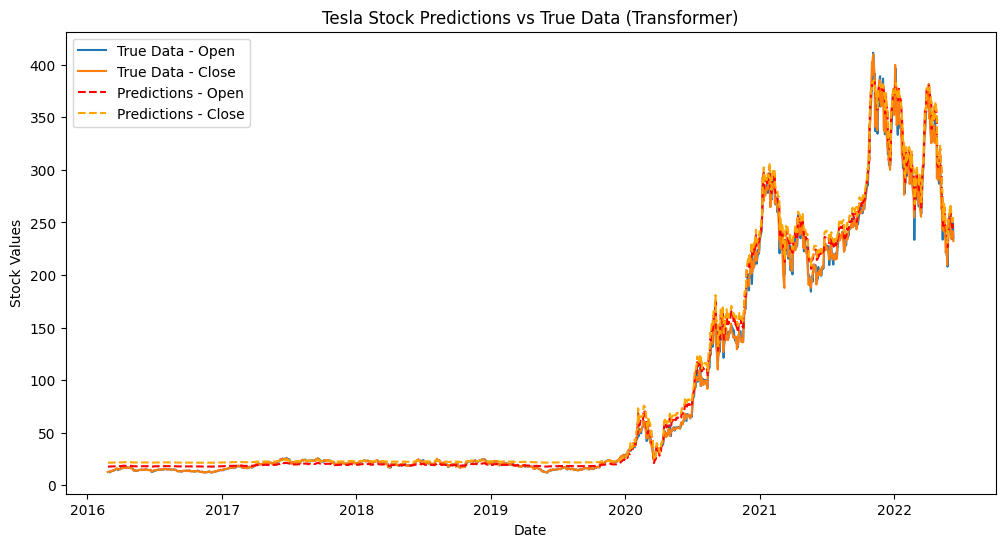

In [18]:
# Make final predictions on training data
model.eval()
with torch.no_grad():
    predictions_final = model(torch.tensor(X_train_tesla, dtype=torch.float32), 
                              torch.tensor(X_train_tesla, dtype=torch.float32))

# Convert predictions back to original scale
# Inverse transform the predicted values (use the last time step of the predictions)
predictions_final_np = scaler.inverse_transform(predictions_final[:, -1, :].cpu().numpy())

# Inverse transform the actual values for comparison
y_train_actual = scaler.inverse_transform(y_train_tesla.reshape(-1, 2))

# Plot predictions vs. actual values
plt.figure(figsize=(12, 6))
plt.plot(df_train.index[window_size:], y_train_actual[:, 0], label="True Data - Open")
plt.plot(df_train.index[window_size:], y_train_actual[:, 1], label="True Data - Close")

plt.plot(df_train.index[window_size:], predictions_final_np[:, 0], label="Predictions - Open", color='red', linestyle="dashed")
plt.plot(df_train.index[window_size:], predictions_final_np[:, 1], label="Predictions - Close", color='orange', linestyle="dashed")

plt.legend()
plt.title('Tesla Stock Predictions vs True Data (Transformer)')
plt.xlabel('Date')
plt.ylabel('Stock Values')
plt.show()

Test RMSE: 75.1796


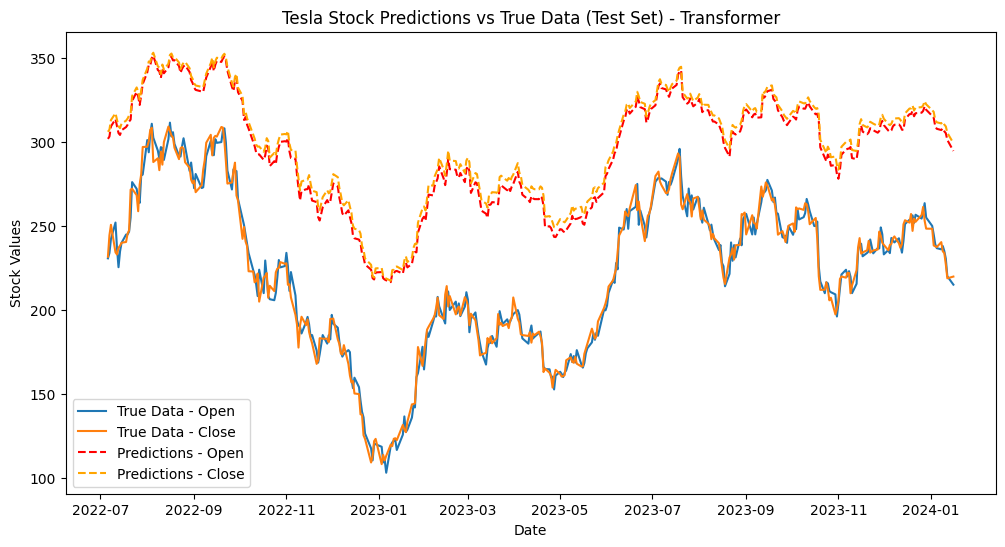

In [20]:
# Prepare test data using the same window size
X_test = [df_test.values[i:i+window_size] for i in range(len(df_test) - window_size)]
y_test = [df_test.values[i + window_size] for i in range(len(df_test) - window_size)]

X_test = np.array(X_test)
y_test = np.array(y_test)

# Convert to PyTorch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Make predictions on test data using the trained Transformer model
model.eval()
with torch.no_grad():
    predictions_test_tensor = model(X_test_tensor, X_test_tensor)  # Decoder input is same as encoder

# Convert predictions back to NumPy array
predictions_test = predictions_test_tensor[:, -1, :].cpu().numpy()

# Reverse scaling to get original values
predictions_test = scaler.inverse_transform(predictions_test.reshape(-1, 2))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 2))

# Calculate RMSE for test data
rmse_test = np.sqrt(mean_squared_error(y_test_actual, predictions_test))
print(f"Test RMSE: {rmse_test:.4f}")

# Plot test predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(df_test.index[window_size:], y_test_actual[:, 0], label="True Data - Open")
plt.plot(df_test.index[window_size:], y_test_actual[:, 1], label="True Data - Close")

plt.plot(df_test.index[window_size:], predictions_test[:, 0], label="Predictions - Open", color='red', linestyle="dashed")
plt.plot(df_test.index[window_size:], predictions_test[:, 1], label="Predictions - Close", color='orange', linestyle="dashed")

plt.legend()
plt.title('Tesla Stock Predictions vs True Data (Test Set) - Transformer')
plt.xlabel('Date')
plt.ylabel('Stock Values')
plt.show()

In [22]:
df_weather = pd.read_excel('/kaggle/input/weather-data/weatheraqDataset.xlsx')
df_weather.drop(columns=["Unnamed: 0"], errors="ignore", inplace=True)

df_weather["date"] = pd.to_datetime(df_weather["date"])
df_weather.set_index("date", inplace=True)

df_weather = df_weather[["avg_nitrogen_dioxide", "max_nitrogen_dioxide"]]
df_weather = df_weather.iloc[-1500:]  # Last 1500 records (adjustable)

# Scale data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_weather)
df_scaled = pd.DataFrame(scaled_data, columns=df_weather.columns, index=df_weather.index)

In [23]:
# Split into train (80%) and test (20%)
train_size = int(len(df_scaled) * 0.8)
df_train = df_scaled.iloc[:train_size]
df_test = df_scaled.iloc[train_size:]

print(f"Training data size: {len(df_train)}")
print(f"Testing data size: {len(df_test)}")

Training data size: 1168
Testing data size: 293


In [24]:
# Define hyperparameter search space
model_dims = [32, 64]
learning_rates = [0.01, 0.005, 0.001]
epochs_list = [100, 300, 500]
window_sizes = [5, 10, 15]

best_rmse = float("inf")
best_params = None

# Hyperparameter tuning
for model_dim in model_dims:
    for learning_rate in learning_rates:
        for epochs in epochs_list:
            for window_size in window_sizes:
                print(f"Training with ModelDim={model_dim}, LR={learning_rate}, Epochs={epochs}, Window={window_size}")

                # Prepare training data as sequences
                X_train_weather_tuned = [df_train.values[i:i+window_size] for i in range(len(df_train) - window_size)]
                y_train_weather_tuned = [df_train.values[i + window_size] for i in range(len(df_train) - window_size)]
                
                X_train_weather_tuned = np.array(X_train_weather_tuned)
                y_train_weather_tuned = np.array(y_train_weather_tuned)

                # Convert to PyTorch tensors and send to device (GPU or CPU)
                X_train_weather_tuned = torch.tensor(X_train_weather_tuned, dtype=torch.float32).to(device)
                y_train_weather_tuned = torch.tensor(y_train_weather_tuned, dtype=torch.float32).to(device)

                # Initialize Transformer model and send it to device (GPU or CPU)
                model = TransformerTimeSeries(input_dim=2, model_dim=model_dim, num_heads=4, num_layers=2, dropout=0.1).to(device)

                # Define loss function and optimizer
                criterion = nn.MSELoss()
                optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

                # Training loop
                for epoch in range(epochs):
                    model.train()
                    optimizer.zero_grad()

                    # Forward pass
                    Y_pred = model(X_train_weather_tuned, X_train_weather_tuned)

                    # Compute loss
                    loss = criterion(Y_pred[:, -1, :], y_train_weather_tuned)

                    # Backpropagation
                    loss.backward()
                    optimizer.step()

                # Make predictions
                model.eval()
                with torch.no_grad():
                    predictions = model(X_train_weather_tuned, X_train_weather_tuned)

                # Convert predictions back to original scale and move to CPU for further processing
                predictions_np = predictions.cpu().numpy().reshape(-1, 2)
                y_train_actual = y_train_weather_tuned.cpu().numpy().reshape(-1, 2)

                # Select only the last predicted step for each sequence to match y_train_actual
                predictions_np = predictions_np[-len(y_train_actual):]

                # Calculate RMSE
                rmse = np.sqrt(mean_squared_error(y_train_actual, predictions_np))
                print(f"RMSE: {rmse:.4f}")

                # Save best model parameters
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_params = (model_dim, learning_rate, epochs, window_size)

# Print best parameters
print("\nBest Hyperparameters for Weather Data:")
print(f"Model Dim: {best_params[0]}, Learning Rate: {best_params[1]}, Epochs: {best_params[2]}, Window Size: {best_params[3]}")
print(f"Best RMSE: {best_rmse:.4f}")

Training with ModelDim=32, LR=0.01, Epochs=100, Window=5
RMSE: 0.1881
Training with ModelDim=32, LR=0.01, Epochs=100, Window=10
RMSE: 0.1888
Training with ModelDim=32, LR=0.01, Epochs=100, Window=15
RMSE: 0.1869
Training with ModelDim=32, LR=0.01, Epochs=300, Window=5
RMSE: 0.2330
Training with ModelDim=32, LR=0.01, Epochs=300, Window=10
RMSE: 0.2286
Training with ModelDim=32, LR=0.01, Epochs=300, Window=15
RMSE: 0.2435
Training with ModelDim=32, LR=0.01, Epochs=500, Window=5
RMSE: 0.2202
Training with ModelDim=32, LR=0.01, Epochs=500, Window=10
RMSE: 0.2471
Training with ModelDim=32, LR=0.01, Epochs=500, Window=15
RMSE: 0.2543
Training with ModelDim=32, LR=0.005, Epochs=100, Window=5
RMSE: 0.1882
Training with ModelDim=32, LR=0.005, Epochs=100, Window=10
RMSE: 0.2207
Training with ModelDim=32, LR=0.005, Epochs=100, Window=15
RMSE: 0.2193
Training with ModelDim=32, LR=0.005, Epochs=300, Window=5
RMSE: 0.2267
Training with ModelDim=32, LR=0.005, Epochs=300, Window=10
RMSE: 0.2410
Traini

In [28]:
# Window size (set from the best parameters)
window_size = 15

# Prepare training data as sequences
X_train_weather = [df_train.values[i:i+window_size] for i in range(len(df_train) - window_size)]
y_train_weather = [df_train.values[i + window_size] for i in range(len(df_train) - window_size)]

X_train_weather = np.array(X_train_weather)
y_train_weather = np.array(y_train_weather)

# Convert to PyTorch tensors and send to device (GPU or CPU)
X_train_weather = torch.tensor(X_train_weather, dtype=torch.float32).to(device)
y_train_weather = torch.tensor(y_train_weather, dtype=torch.float32).to(device)

# Initialize Transformer model and send it to device (GPU or CPU)
model = TransformerTimeSeries(input_dim=2, model_dim=64, num_heads=4, num_layers=4, dropout=0.1).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the final model
for epoch in range(500):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    Y_pred = model(X_train_weather, X_train_weather)

    # Compute loss
    loss = criterion(Y_pred[:, -1, :], y_train_weather)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Optionally, print the loss every few epochs to monitor progress
    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch+1}/500], Loss: {loss.item():.4f}")

print("Final model training completed.")

Epoch [50/500], Loss: 0.0457
Epoch [100/500], Loss: 0.0398
Epoch [150/500], Loss: 0.0145
Epoch [200/500], Loss: 0.0118
Epoch [250/500], Loss: 0.0110
Epoch [300/500], Loss: 0.0103
Epoch [350/500], Loss: 0.0103
Epoch [400/500], Loss: 0.0103
Epoch [450/500], Loss: 0.0104
Epoch [500/500], Loss: 0.0099
Final model training completed.


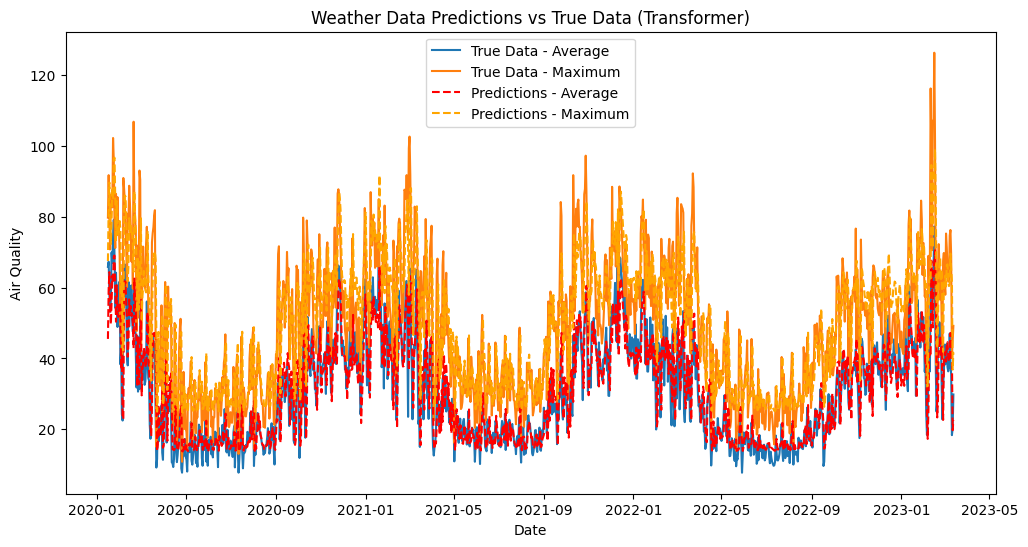

In [29]:
# Make final predictions
model.eval()
with torch.no_grad():
    predictions_final = model(X_train_weather, X_train_weather)

# Move tensors back to CPU for NumPy conversion
predictions_final_np = scaler.inverse_transform(predictions_final[:, -1, :].cpu().numpy())
y_train_actual = scaler.inverse_transform(y_train_weather.cpu().numpy())

# Plot predictions vs. actual values
plt.figure(figsize=(12, 6))
plt.plot(df_train.index[window_size:], y_train_actual[:, 0], label="True Data - Average")
plt.plot(df_train.index[window_size:], y_train_actual[:, 1], label="True Data - Maximum")

plt.plot(df_train.index[window_size:], predictions_final_np[:, 0], label="Predictions - Average", color='red', linestyle="dashed")
plt.plot(df_train.index[window_size:], predictions_final_np[:, 1], label="Predictions - Maximum", color='orange', linestyle="dashed")
plt.legend()
plt.title('Weather Data Predictions vs True Data (Transformer)')
plt.xlabel('Date')
plt.ylabel('Air Quality')
plt.show()

Test RMSE: 9.0640


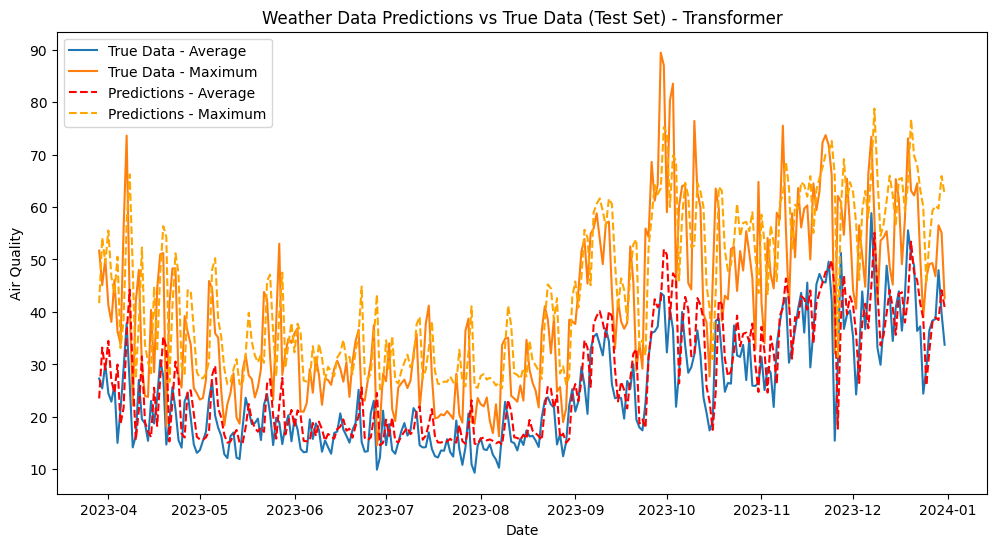

In [30]:
# Prepare test data using the same window size
X_test = [df_test.values[i:i+window_size] for i in range(len(df_test) - window_size)]
y_test = [df_test.values[i + window_size] for i in range(len(df_test) - window_size)]

X_test = np.array(X_test)
y_test = np.array(y_test)

# Convert to PyTorch tensors and move to device
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# Make predictions on test data using the trained Transformer model
model.eval()
with torch.no_grad():
    predictions_test_tensor = model(X_test_tensor, X_test_tensor)  # Decoder input is same as encoder

# Convert predictions back to NumPy array
predictions_test = predictions_test_tensor[:, -1, :].cpu().numpy()
y_test_actual = y_test_tensor.cpu().numpy()

# Reverse scaling to get original values
predictions_test = scaler.inverse_transform(predictions_test.reshape(-1, 2))
y_test_actual = scaler.inverse_transform(y_test_actual.reshape(-1, 2))

# Calculate RMSE for test data
rmse_test = np.sqrt(mean_squared_error(y_test_actual, predictions_test))
print(f"Test RMSE: {rmse_test:.4f}")

# Plot test predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(df_test.index[window_size:], y_test_actual[:, 0], label="True Data - Average")
plt.plot(df_test.index[window_size:], y_test_actual[:, 1], label="True Data - Maximum")

plt.plot(df_test.index[window_size:], predictions_test[:, 0], label="Predictions - Average", color='red', linestyle="dashed")
plt.plot(df_test.index[window_size:], predictions_test[:, 1], label="Predictions - Maximum", color='orange', linestyle="dashed")

plt.legend()
plt.title('Weather Data Predictions vs True Data (Test Set) - Transformer')
plt.xlabel('Date')
plt.ylabel('Air Quality')
plt.show()